# MS 2.1- Group 10

The following sections describe and implement an attempt to Audio Identification. We experimented with various configurations and parameter settings to achieve a high accuracy in the audio identification of our test queries. 

# Task 1:

## Dataset
The data audio tracks used in this notebook can be found at https://cdn.freesound.org/mtg-jamendo/raw_30s/audio/raw_30s_audio-10.tar.

### Query Generation
We began by randomly selecting 20 audio tracks from the dataset. These tracks serve as the foundation for generating our test queries. For each of the 20 selected tracks, we extracted a 10-second segment from within the first 20 seconds of the track. Using the tool Audacity, we then created four distinct query versions for each extracted segment:

- **Original**: The unmodified 10-second segment.
- **Noise**: The segment with added Gaussian noise.
- **Coding**: A strongly compressed version of the segment.
- **Mobile**: A version recorded outdoors using a mobile phone.

### Data Organization
- **Full Tracks**: Stored in the **'tracks/'** folder.
- **Generated Queries**: Stored in the **'queries/'** folder.

*Note: All audio files are saved in MP3 format*

# Task 2-4:


# Imports

In [1]:
# imports
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
from IPython.display import clear_output


%matplotlib inline

# Utility functions

Here we define all functions that, we later need to compute spectrograms, constellation maps, and perform the matching

### Spectrogram
This function is responsible for computing the spectrogram map of a given track. We limit the track duration that is used to 30 seconds.

In [2]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None, duration=None):
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

### Constellation map 
This function computes the constellation map, given a spectrogram map

In [3]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

### Plot constellation map
Function to plot the constellation map. Used for inspection purposes, when deciding on parameters for dist_freq and dist_time.

In [4]:
def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    

Helper function that matches two binary matrices.

In [5]:
import numpy as np
from scipy import ndimage
from numba import jit, prange
def match_binary_matrices_tol(C_ref, C_est, C_est_max, tol_freq=0, tol_time=0):
    """Compare binary matrices with tolerance."""
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND

### Compute Matching function

The following two functions compute the match between the query constellation map and the database-track constellation map by sliding the query over the database-track.

To optimize query-to-database constellation map matching, we refactored the original implementation into compute_matching_function and compute_matching_function_numba. The former precomputes the C_est_max filter to estimate the query's maximum region, while the latter is Numba-optimized, leveraging parallelization across CPU cores to reduce runtime from nearly an hour to under 5 minutes.

We chose True Positives (TP) as the primary scoring metric because it provided the most consistent and interpretable results. Unlike precision, recall, or F-measure, TP is straightforward and does not depend on thresholds or additional parameters, making it suitable for comparing scores across different constellation maps. This choice aligns with the reference implementation and focuses on maximizing correct matches, ensuring robust and reliable evaluations for this task.

In [6]:
@jit(nopython=True, parallel=True)
def compute_matching_function_numba(C_D, C_Q, C_est_max, tol_freq=0, tol_time=0):
    """Numba-accelerated computation of the matching function."""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    Delta = np.zeros(M + 1, dtype=np.float64)

    for m in prange(M + 1):  # Parallelized loop
        C_D_crop = C_D[:, m:m + N]
        C_AND = np.logical_and(C_est_max, C_D_crop)
        TP = np.sum(C_AND)
        Delta[m] = TP

    shift_max = np.argmax(Delta)
    return Delta, shift_max

In [7]:
def compute_matching_function(C_D, C_Q, tol_freq=0, tol_time=0):
    """Computes matching function for constellation maps."""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"

    # Precompute the max filter for the estimation (outside of Numba)
    C_est_max = ndimage.maximum_filter(C_Q, size=(2 * tol_freq + 1, 2 * tol_time + 1), mode='constant')

    # Use the Numba-accelerated version
    Delta, shift_max = compute_matching_function_numba(C_D, C_Q, C_est_max, tol_freq, tol_time)
    return Delta, shift_max

### Load all filenames
This function is used to load all filenames, that are contained in a specified directory. 

In [8]:
def load_filenames(directory):
    filenames = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Create the full path
        file_path = os.path.join(directory, filename)
        
        # Check if it is a file (not a directory)
        if os.path.isfile(file_path):
            # Add to the dictionary, using the filename as the key
            filenames.append(file_path)

    return filenames

### Compute constellation maps for given filenames
The following functions compute constellation maps for a given list of track or query filenames. To optimize performance, the computation is multithreaded, significantly reducing the processing time. For each file, the process involves computing the spectrogram and subsequently generating the corresponding constellation map.

In [9]:
from concurrent.futures import ThreadPoolExecutor

def compute_constellation_map_single(args):
    """Compute the constellation map for a single file."""
    filename, dist_freq, dist_time = args
    spectrogram = compute_spectrogram(filename)  # Perform I/O and computation
    constellation_map = compute_constellation_map(spectrogram, dist_freq, dist_time)
    return filename, constellation_map

def compute_constellation_maps(filenames, dist_freq, dist_time):
    """Compute constellation maps using multithreading."""
    # Prepare arguments for each file
    args = [(filename, dist_freq, dist_time) for filename in filenames]
    
    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor() as executor:
        results = executor.map(compute_constellation_map_single, args)
    
    # Convert results to a dictionary
    Cmaps = dict(results)
    return Cmaps

# Task 2: Database Preparation
In this section, we prepare the database for our experiments by defining and initializing configurations and computing constellation maps.

Each configuration is represented as a dictionary that specifies various parameters (e.g., κ, τ, tol_freq, tol_time) and also serves as a container for storing:

- **Constellation Maps for Database Tracks (cmaps_D)**: Computed constellation maps for the database tracks.
- **Constellation Maps for Queries (cmaps_Q)**: Computed constellation maps for the queries.
- **Matches**: A dictionary to store matches between database tracks and queries calculated during experiments.
- **Hits**: A summary of total and query-specific matches across different query types (original, noise, coding, and mobile).

## Configurations
We create an array of four configurations, each with different parameter values, and initialize the respective fields. The constellation maps are computed for each configuration and stored in the configs data structure for use in subsequent experiments.

In [10]:
configs = [
    {"kappa": 7, "tau": 3, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 11, "tau": 3, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 10, "tau": 10, "tol_freq": 0, "tol_time": 0, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}},
    {"kappa": 6, "tau": 17, "tol_freq": 1, "tol_time": 2, "cmaps_D": None, "cmaps_Q": None, "matches": {}, "hits": {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}}
]

Now we load all tracks we want to have in our database into memory and compute the constellation maps for each of the 4 specified configurations.

In [11]:
tracks = load_filenames('tracks') # load all track filenames
for config in configs: 
    config["cmaps_D"] = compute_constellation_maps(tracks, config["kappa"], config["tau"]) # store the computed constellation maps for each configuration.

## Visualization of example constellation maps for each configuration
Here, we illustrate how a constellation map for a track appears for each selected configuration, using the specified parameters. This demonstration provides a visual representation of how the parameter settings (κ, τ) influence the resulting constellation map for a given track.

### κ = 7, τ = 3

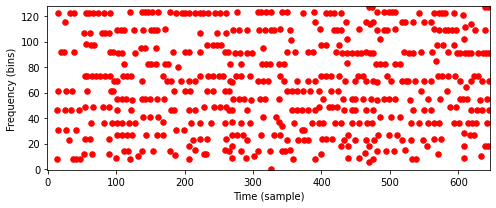

In [12]:
fig, ax, im = plot_constellation_map(configs[0]["cmaps_D"]['tracks/810.mp3'], color='r', s=30)

### κ = 11, τ = 3

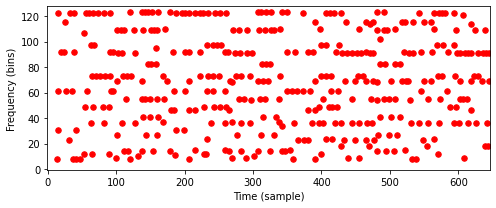

In [13]:
fig, ax, im = plot_constellation_map(configs[1]["cmaps_D"]['tracks/810.mp3'], color='r', s=30)

### κ = 10, τ = 10

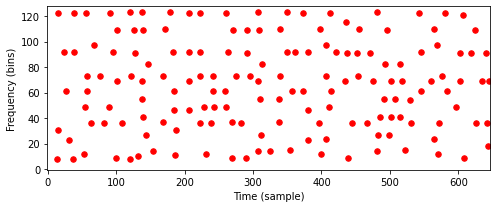

In [14]:
fig, ax, im = plot_constellation_map(configs[2]["cmaps_D"]['tracks/810.mp3'], color='r', s=30)

### κ = 6, τ = 17

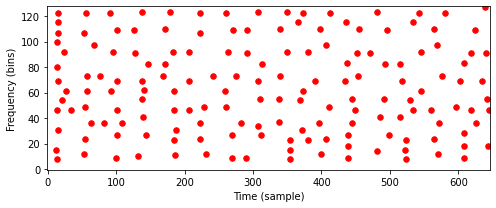

In [15]:
fig, ax, im = plot_constellation_map(configs[3]["cmaps_D"]['tracks/810.mp3'], color='r', s=30)

# Task 3: Retrieval Experimentation

- In this section, we begin by generating constellation maps for each query using the same parameter combinations applied to the database tracks. This ensures a consistent basis for comparison during the matching process.

- Next, we perform the matching process for each of the four configurations. Each test query is compared against all audio tracks in the database, and the track with the highest similarity score is identified as the best match.

- Finally, we evaluate and visualize the results for each configuration, presenting the outcomes using detailed figures and a summary table for clear comparison.

Here again, we load all the test queries into memory and compute their constellation maps for each of the four specified configurations.

In [16]:
queries = load_filenames('queries')
for config in configs: 
    config["cmaps_Q"] = compute_constellation_maps(queries, config["kappa"], config["tau"])

## Visualization of example constellation maps for each configuration
Here, we illustrate how a constellation map for a query appears for each selected configuration, using the specified parameters. This demonstration provides a visual representation of how the parameter settings (κ, τ) influence the resulting constellation map for a given query.

### κ = 7, τ = 3

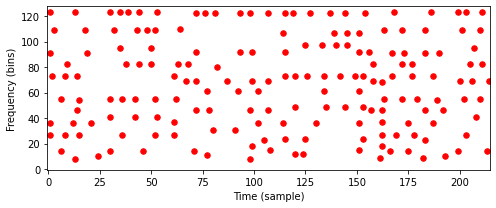

In [17]:
fig, ax, im = plot_constellation_map(configs[0]["cmaps_Q"]['queries/810.mp3'], color='r', s=30)

### κ = 11, τ = 3

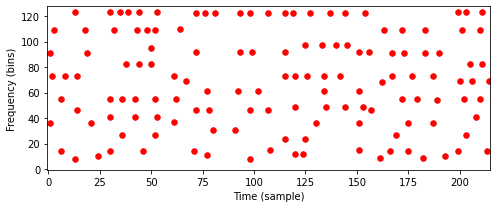

In [18]:
fig, ax, im = plot_constellation_map(configs[1]["cmaps_Q"]['queries/810.mp3'], color='r', s=30)

### κ = 10, τ = 10

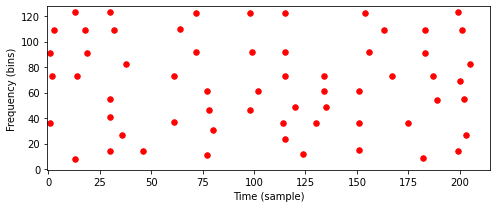

In [19]:
fig, ax, im = plot_constellation_map(configs[2]["cmaps_Q"]['queries/810.mp3'], color='r', s=30)

### κ = 6, τ = 17

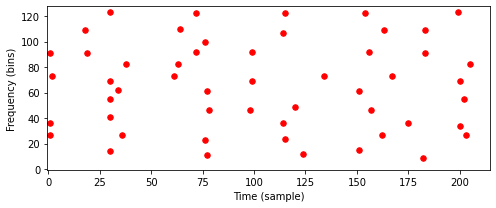

In [20]:
fig, ax, im = plot_constellation_map(configs[3]["cmaps_Q"]['queries/810.mp3'], color='r', s=30)

## Matching

After preprocessing our tracks and queries, we can finally start the matching. We do the matching of queries and database-tracks for each of the previously defined parameter combinations. 

For each configuration, we follow a systematic process to identify the best match for each query:

- **Iterate Through Queries**: For every query, its constellation map is compared against all the database track constellation maps.
- **Compute Matching Scores**: Using the compute_matching_function, a score is calculated for each query-to-track combination.
- **Track the Best Match**: The track with the highest matching score for each query is identified as the best match. This is stored in a dictionary along with its corresponding score.
- **Evaluate Results**: We determine how many queries were correctly matched to their corresponding tracks by comparing the predicted matching track to the query's expected match.

In [21]:


for config in configs: # loop through all 4 configurations
    print(f"***** Configuration: κ={config['kappa']}, τ={config['tau']} *****")
    
    config["hits"] = {"total": 0, "original": 0, "noise": 0, "coding": 0, "mobile": 0}
    
    for name_Q, cmap_Q in config["cmaps_Q"].items(): # test all queries one by one
        best_score = 0
        best_name = None


        start_time = time.time() # measure time

        for name_D, cmap_D in config["cmaps_D"].items(): # compare query to all database tracks
            delta, shift_max = compute_matching_function(cmap_D, cmap_Q, tol_freq=config["tol_freq"], tol_time=config["tol_time"])

            if delta[shift_max] > best_score:
                best_score = delta[shift_max]
                best_name = name_D

    
        end_time = time.time()
        
        # save best matching track
        config["matches"][name_Q] = {"matching_track": best_name, "score": best_score, "time": (end_time-start_time)}

        # keep track of hits - it is a hit if the track number of the query filename is the same as of the track filename
        track_num = name_Q.split('/')[1].split('_')[0] 
        if track_num in best_name:
            config["hits"]["total"] += 1 # total hits

            if "noise" in name_Q:
                config["hits"]["noise"] += 1 # if query was a noise query
            elif "coding" in name_Q:
                config["hits"]["coding"] += 1 # if query was a coding query
            elif "mobile" in name_Q:
                config["hits"]["mobile"] += 1 # if query was a mobile query
            else:
                config["hits"]["original"] += 1 # if query the orginal extracted segment


    total_time = sum(entry["time"] for entry in config["matches"].values()) # total time it took for all queries of the given configuration
    average_time = total_time / len(config["matches"]) if config["matches"] else 0 # average query time of given configuration

    # print out short statistics for each configuration
    print(f"Average time per query: {average_time:.2f} seconds")
    print(f"Matched {config['hits']['total']} of {len(queries)} queries correctly.")
    print(f"Original: {config['hits']['original']} / {20}.")
    print(f"Noise: {config['hits']['noise']} / {20}.")
    print(f"Coding: {config['hits']['coding']} / {20}.")
    print(f"Mobile: {config['hits']['mobile']} / {20}.")

    
    
    print("\n\n")
    


***** Configuration: κ=7, τ=3 *****
Average time per query: 0.55 seconds
Matched 73 of 80 queries correctly.
Original: 20 / 20.
Noise: 19 / 20.
Coding: 20 / 20.
Mobile: 14 / 20.



***** Configuration: κ=11, τ=3 *****
Average time per query: 0.39 seconds
Matched 74 of 80 queries correctly.
Original: 20 / 20.
Noise: 19 / 20.
Coding: 20 / 20.
Mobile: 15 / 20.



***** Configuration: κ=10, τ=10 *****
Average time per query: 0.39 seconds
Matched 70 of 80 queries correctly.
Original: 20 / 20.
Noise: 18 / 20.
Coding: 20 / 20.
Mobile: 12 / 20.



***** Configuration: κ=6, τ=17 *****
Average time per query: 0.49 seconds
Matched 76 of 80 queries correctly.
Original: 20 / 20.
Noise: 20 / 20.
Coding: 20 / 20.
Mobile: 16 / 20.





 # Evaluation:
 In this section, we evaluate we compare and visualize our experiments.

## Table

In [22]:
import pandas as pd




# Example data
average_times = []
for config in configs:
    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0
    average_times.append(average_time)

max_times = [max(entry["time"] for entry in config["matches"].values()) for config in configs]
min_times = [min(entry["time"] for entry in config["matches"].values()) for config in configs]



data = {
    "Average Query Time (sec)": average_times,
    "Max Query Time (sec)": max_times,
    "Min Query Time (sec)": min_times,
    "Total Accuracy (%)": [config["hits"]["total"]/len(queries) for config in configs],
    "Original Accuracy (%)": [(config["hits"]["original"]/20)*100 for config in configs],
    "Noise Accuracy (%)": [(config["hits"]["noise"]/20)*100 for config in configs],
    "Coding Accuracy (%)": [(config["hits"]["coding"]/20)*100 for config in configs],
    "Mobile Accuracy (%)": [(config["hits"]["mobile"]/20)*100 for config in configs],
}

# Row labels
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]

# Create the DataFrame
df = pd.DataFrame(data, index=labels)
df

,Average Query Time (sec),Max Query Time (sec),Min Query Time (sec),Total Accuracy (%),Original Accuracy (%),Noise Accuracy (%),Coding Accuracy (%),Mobile Accuracy (%)
"kappa=7, tau=3",0.547054,1.888280,0.298087,0.9125,100.0,95.0,100.0,70.0
"kappa=11, tau=3",0.388381,1.101265,0.316100,0.9250,100.0,95.0,100.0,75.0
"kappa=10, tau=10",0.385556,1.130261,0.304117,0.8750,100.0,90.0,100.0,60.0
"kappa=6, tau=17",0.490787,1.135695,0.399142,0.9500,100.0,100.0,100.0,80.0


This table summarizes the performance metrics of our configurations, defined by the parameters κ and  τ. The configurations are evaluated based on multiple factors:

- **Average Query Time (sec)**: The average time taken to process a query.
- **Max Query Time (sec)**: The longest time recorded for a query.
- **Min Query Time (sec)**: The shortest time recorded for a query.
- **Total Accuracy (%)**: The overall percentage of correctly processed queries.
- **Original Accuracy (%)**: The accuracy of queries without any additional challenges, such as noise.
- **Noise Accuracy (%)**: The accuracy when noise is present.
- **Coding Accuracy (%)**: The accuracy for coding queries.
- **Mobile Accuracy (%)**: The accuracy for mobile queries.


## Query time comparison

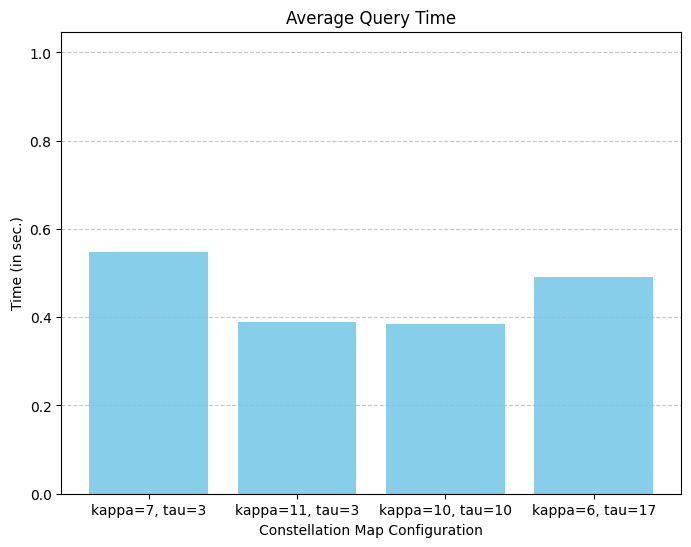

In [23]:
import matplotlib.pyplot as plt

# Values to plot
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
values = [] 

for config in configs:
    total_time = sum(entry["time"] for entry in config["matches"].values())
    average_time = total_time / len(config["matches"]) if config["matches"] else 0
    values.append(average_time)

# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.title('Average Query Time')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Time (in sec.)')
plt.ylim(0, max(values) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

This figure illustrates the average query time required to find a match for each configuration of 𝜅 and 𝜏. The configurations are displayed on the x-axis, while the average query time (in seconds) is shown on the y-axis.

In our case, changing the parameters did not really influence the runtime much.

## Matching Accuracy Comparison

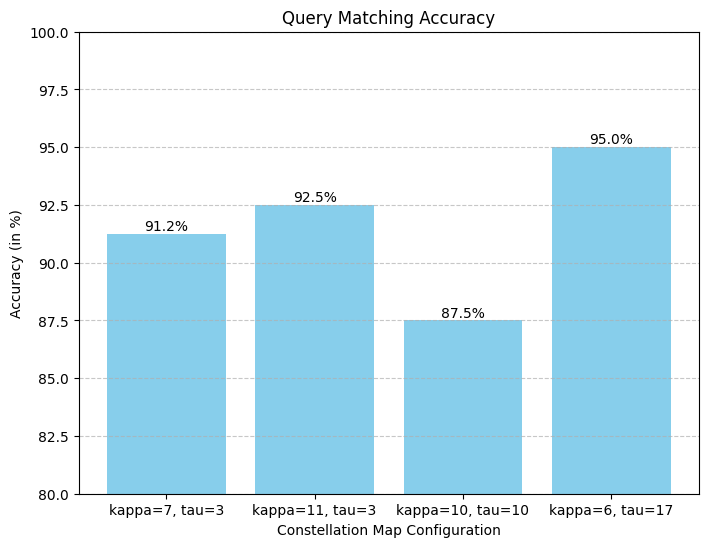

In [24]:
import matplotlib.pyplot as plt


# Values to plot
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
values = [config["hits"]["total"]/len(queries)*100 for config in configs]


# Creating the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color='skyblue')

# Adding percentages above the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, 
             f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# Adding title and labels
plt.title('Query Matching Accuracy')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Accuracy (in %)')
plt.ylim(80, 100)  # Leave some space above the bars for annotations
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


This figure visualizes the query matching accuracy for each configuration, based on the parameters 𝜅 and 𝜏. The x-axis represents the configuration, while the y-axis shows the accuracy percentage.

From the chart:
- The configuration κ=10,τ=10 has the lowest accuracy (87.5%), making it the least effective in correctly matching queries.
- The configuration κ=17,τ=6 achieves the highest accuracy (95%), closely followed by κ=11,τ=3 and κ=7,τ=3, with 92.5% and 91.2% respectively.

This highlights how parameter tuning significantly impacts query matching performance, with some configurations offering more consistent and accurate results.

## Category Comparison

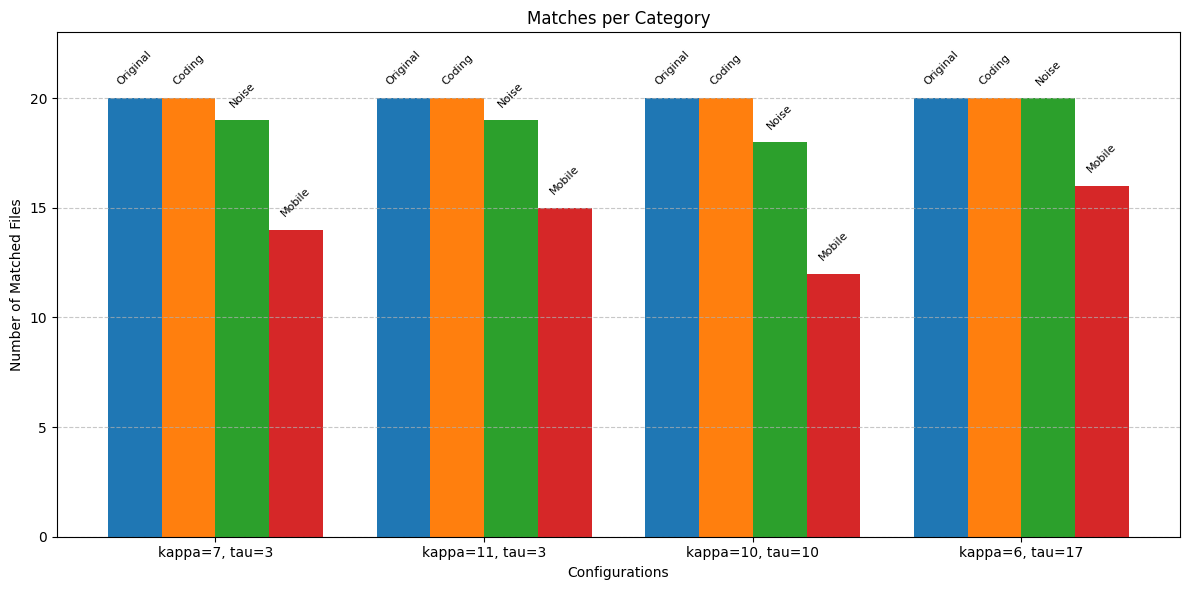

In [25]:
# Configuration names and corresponding counts for each category
labels = [f"kappa={config['kappa']}, tau={config['tau']}" for config in configs]
matched_original = [config["hits"]["original"] for config in configs]
matched_coding = [config["hits"]["coding"] for config in configs]
matched_noise = [config["hits"]["noise"] for config in configs]
matched_mobile = [config["hits"]["mobile"] for config in configs]

# Number of configurations
num_configs = len(labels)

# X positions for groups of bars
x = np.arange(num_configs)

# Width of each bar
bar_width = 0.2

# Categories and their data
categories = ['Original', 'Coding', 'Noise', 'Mobile']
data = [matched_original, matched_coding, matched_noise, matched_mobile]

# Plot
plt.figure(figsize=(12, 6))

for i, category_data in enumerate(data):
    # Offset for each bar in a group
    bar_positions = x + (i - 1.5) * bar_width
    bars = plt.bar(bar_positions, category_data, width=bar_width)
    
    # Add category labels on top of each bar
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Adjusted offset for more space
                 categories[i], ha='center', va='bottom', rotation=45, fontsize=8)

# Add labels, title, and legend
plt.xlabel('Configurations')
plt.ylabel('Number of Matched Files')
plt.title('Matches per Category')
plt.xticks(x, labels)

# Adjust the y-axis to leave more space at the top
plt.ylim(0, max(max(matched_original), max(matched_coding), max(matched_noise), max(matched_mobile)) + 3)

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This figure allows us to evaluate where the most errors occur in query matching. Queries extracted directly from the original track, without any modifications, consistently achieve a perfect match. Similarly, queries with coding modifications also maintain 100% accuracy.

However, queries with artificially added noise perform slightly worse, as they are not matched as frequently. The poorest performance is observed with mobile queries, where some configurations manage to achieve only slightly over 50% accuracy.

This analysis highlights the challenges posed by noisy and mobile-modified queries.


------------------

kappa: 7 | tau: 3 | tol_freq: 0 | tol_time: 0
Maximum Score:
                   Query  Score
41  queries/1084710.mp3  221.0

Minimum Score:
                         Query  Score
76  queries/262010_mobile.mp3   10.0

Average Score: 95.975
Average Score for `mobile` Queries: 33.4
Average Score for `coding` Queries: 104.65
Average Score for `noise` Queries: 104.85

------------------

kappa: 11 | tau: 3 | tol_freq: 0 | tol_time: 0
Maximum Score:
                   Query  Score
28  queries/1390710.mp3  156.0

Minimum Score:
                         Query  Score
6  queries/1147910_mobile.mp3    7.0

Average Score: 66.575
Average Score for `mobile` Queries: 22.9
Average Score for `coding` Queries: 73.1
Average Score for `noise` Queries: 74.75

------------------

kappa: 10 | tau: 10 | tol_freq: 0 | tol_time: 0
Maximum Score:
                   Query  Score
28  queries/1390710.mp3   58.0

Minimum Score:
                         Query  Score
6  queries/1147910_mobile.mp3  

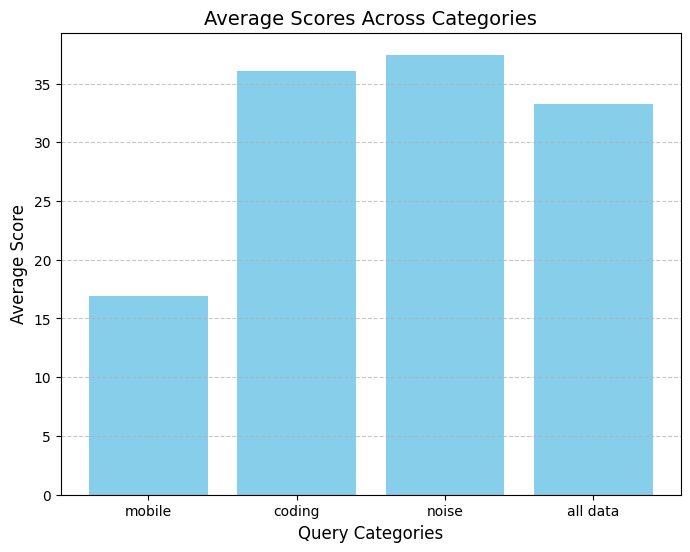

In [28]:
keys_to_print = ['kappa', 'tau', 'tol_freq', 'tol_time']
print("\n------------------\n")

for config in configs:
    key_values = " | ".join(f"{key}: {config[key]}" for key in keys_to_print if key in config)
    print(f"{key_values}")
    
    # Extract matches data
    matches_data = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
    ]
    matches_data_mobile = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "mobile" in query_name.lower()
    ]
    matches_data_code = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "coding" in query_name.lower()
    ]
    matches_data_noise = [
        {"Query": query_name, "Score": details["score"]}
        for query_name, details in config["matches"].items()
        if "noise" in query_name.lower()
    ]

    average_scores = {"mobile": [], "coding": [], "noise": [], "all data": []}

    # Create DataFrames
    df = pd.DataFrame(matches_data)
    df_m = pd.DataFrame(matches_data_mobile)
    df_c = pd.DataFrame(matches_data_code)
    df_n = pd.DataFrame(matches_data_noise)
    
    # Ensure "Score" column is numeric where applicable
    df["Score"] = pd.to_numeric(df["Score"])
    average_score_m = None
    if not df_m.empty:
        df_m["Score"] = pd.to_numeric(df_m["Score"])
        average_score_m = df_m["Score"].mean()
    average_score_c = None
    if not df_c.empty:
        df_c["Score"] = pd.to_numeric(df_c["Score"])
        average_score_c = df_c["Score"].mean()
    average_score_n = None
    if not df_n.empty:
        df_n["Score"] = pd.to_numeric(df_n["Score"])
        average_score_n = df_n["Score"].mean()
    average_score_o = None

    for category, matches in zip(
        ["mobile", "coding", "noise", "all data"],
        [df_m, df_c, df_n, df]
    ):
        df = pd.DataFrame(matches)
        if not df.empty:
            df["Score"] = pd.to_numeric(df["Score"])
            average_scores[category].append(df["Score"].mean())
    
    # Calculate max, min, and average for all queries
    max_row = df.nlargest(1, "Score")
    min_row = df.nsmallest(1, "Score")
    average_score = df["Score"].mean()

    # Print Results
    print("Maximum Score:\n", max_row)
    print("\nMinimum Score:\n", min_row)
    print("\nAverage Score:", average_score)
    print("Average Score for `mobile` Queries:", average_score_m)
    print("Average Score for `coding` Queries:", average_score_c)
    print("Average Score for `noise` Queries:", average_score_n)
    print("\n------------------\n")

final_averages = {cat: pd.Series(scores).mean() for cat, scores in average_scores.items() if scores}

plt.figure(figsize=(8, 6))
categories = list(final_averages.keys())
scores = list(final_averages.values())

plt.bar(categories, scores, color='skyblue')
plt.title("Average Scores Across Categories", fontsize=14)
plt.xlabel("Query Categories", fontsize=12)
plt.ylabel("Average Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The scores seem reasonable based on the configurations. Higher maximum scores, such as 221.0 in kappa: 7 | tau: 3, make sense because lower tau and tolerances allow more matches between query and track peaks. As tau and tol_time increase (stricter criteria), the average and maximum scores decrease, which is expected since stricter matching reduces alignment between peaks.

Low minimum scores, like 4.0 in kappa: 10 | tau: 10, are logical for stricter configurations or when the query-track pair has fewer matches. The overall trend of decreasing average scores with stricter settings also aligns with the expectations.

The consistency of certain queries appearing in both high and low scores across configurations indicates that the system is processing data as expected. If the configurations match your use case, these scores are valid and meaningful.

Additionally it  makes sense for the scores to be lower for mobile queries. Mobile recordings often introduce distortions. 
These factors naturally lead to fewer matching peaks and, therefore, lower scores. This is consistent with what one can observ and is a good indicator that the scoring system is accounting for real-world variations in query quality.

# Thought process and Final Conclusion

Throughout our notebook, we experimented extensively with different parameter configurations for the constellation maps (κ, τ) and the matching process (dist_freq, dist_time). These experiments revealed how changes to these parameters impact the accuracy of the matching process.

### Insights on Key Parameters:
#### Constellation Map Parameters (κ, τ)**:

- **κ (Frequency Domain)**: This parameter determines how much of the frequency range is considered when detecting peaks in the spectrogram. A smaller κ captures fine details, which can help identify subtle features but increases sensitivity to noise. A larger κ smooths the frequency data, emphasizing dominant peaks while reducing noise sensitivity. However, this can result in overlooking some important details.
- **τ (Time Domain)**: Similar to κ, but applies to the time axis. A smaller τ captures rapid temporal changes, which is beneficial for detecting short, sharp features but also makes the system more sensitive to noise. A larger τ smooths temporal variations, making the system more robust to distortions like jitter or background noise, though it may miss rapid changes.
- **Matching Process Parameters (dist_freq, dist_time)**: Adjusting these parameters, which influence the tolerance in frequency and time domains during the matching process, did not yield significant improvements. Increasing these values often resulted in worse performance. Consequently, we primarily kept them at 0 or 1.

#### Findings and Challenges:
Through our experiments, we identified configurations that balance accuracy and robustness, successfully matching most of the generated test queries. However, matching the mobile queries proved particularly challenging. As shown in the Evaluation Section, mobile queries consistently performed the worst in terms of accuracy, likely due to distortions introduced during outdoor recording.

#### Best Configuration:

The configuration that delivered the best results was:
- **κ = 6, τ = 17, tol_freq = 1, tol_time = 2**
This setup achieved a strong balance between accuracy and robustness, providing the best performance across most query types.
